# Part 2: Time Analyze

### In this part we will focus and analyze the affect of the time on the success of a Kickstarter project.

## Imports & Configurations

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

--2023-02-26 08:58:09--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-26 08:58:10 ERROR 404: Not Found.


gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 12.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=b3b94e0567c715ad35a8f105fc66cde12860a714

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import findspark
import random
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession.builder.config("spark.driver.memory", "2g")\
    .config("spark.executor.memory", "2g") \
    .config('spark.executor.cores', '3') \
    .config('spark.cores.max', '3') \
    .appName("time").getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 10)
spark.conf.set("spark.default.parallelism", 10)

## Read the Data

In [5]:
# Use Spark to read the csv file.
df = spark.read.csv("/content/drive/MyDrive/BDP Final Project/Notebooks/Data/prepared_data.csv",
                    inferSchema=True,
                    header=True)

In [6]:
df.show()

+----------+---------------------+--------------------+-------------+-----------+-----------------+------------------+--------------------+--------+--------+-------+----------------+-------------------+--------------+-------------------+-----------------+-------------------+----------------------+----------------------+---------------------+------------+---------+----------+----------------+--------------+-------------+----------------+-------------+------------------------------+------------------------------+----------+-----------+-------------------+--------------------------+--------------+----------------------+--------------------+-------------------+-------------------+------------------------------------+---------------------------+------------------+---------------+----------------+----------------------+
|        id|                 name|               blurb|backers_count|category_id|    category_name|category_parent_id|category_parent_name|currency| pledged|   goal|created_a

#Part 2.1: Analyze Time 

## Create new Features

Add new columns - hour, day, month, year, weekday by launched date and deadline, add duration between launched date to deadline:

In [7]:
df = df\
.withColumn('launched_at_year', F.year(F.to_timestamp(F.col('launched_at_value'), 'MM-dd-yyyy HH:mm:ss')))\
.withColumn('launched_at_month', F.month(F.to_timestamp(F.col('launched_at_value'), 'MM-dd-yyyy HH:mm:ss')))\
.withColumn('launched_at_day_of_month', F.dayofmonth(F.to_timestamp(F.col('launched_at_value'), 'MM-dd-yyyy HH:mm:ss')))\
.withColumn('launched_at_hour', F.hour(F.to_timestamp(F.col('launched_at_value'), 'MM-dd-yyyy HH:mm:ss')))\
.withColumn('launched_at_day_of_week', F.dayofweek(F.to_timestamp(F.col('launched_at_value'), 'MM-dd-yyyy HH:mm:ss')))\
.withColumn('deadline_year', F.year(F.to_timestamp(F.col('deadline_value'), 'MM-dd-yyyy HH:mm:ss')))\
.withColumn('deadline_month', F.month(F.to_timestamp(F.col('deadline_value'), 'MM-dd-yyyy HH:mm:ss')))\
.withColumn('deadline_day_of_month', F.dayofmonth(F.to_timestamp(F.col('deadline_value'), 'MM-dd-yyyy HH:mm:ss')))\
.withColumn('deadline_hour', F.hour(F.to_timestamp(F.col('deadline_value'), 'MM-dd-yyyy HH:mm:ss')))\
.withColumn('deadline_day_of_week', F.dayofweek(F.to_timestamp(F.col('deadline_value'), 'MM-dd-yyyy HH:mm:ss')))\
.withColumn('duration', F.datediff(F.to_timestamp(F.col('deadline_value'), 'MM-dd-yyyy HH:mm:ss'),
            F.to_timestamp(F.col('launched_at_value'), 'MM-dd-yyyy HH:mm:ss')))

In [8]:
df.show()

+----------+---------------------+--------------------+-------------+-----------+-----------------+------------------+--------------------+--------+--------+-------+----------------+-------------------+--------------+-------------------+-----------------+-------------------+----------------------+----------------------+---------------------+------------+---------+----------+----------------+--------------+-------------+----------------+-------------+------------------------------+------------------------------+----------+-----------+-------------------+--------------------------+--------------+----------------------+--------------------+-------------------+-------------------+------------------------------------+---------------------------+------------------+---------------+----------------+----------------------+----------------+-----------------+------------------------+----------------+-----------------------+-------------+--------------+---------------------+-------------+---------

Filter out rows with duration less than or equal to 0:

In [9]:
df = df.filter(F.col('duration') > 0)

In [10]:
df.show()

+----------+---------------------+--------------------+-------------+-----------+-----------------+------------------+--------------------+--------+--------+-------+----------------+-------------------+--------------+-------------------+-----------------+-------------------+----------------------+----------------------+---------------------+------------+---------+----------+----------------+--------------+-------------+----------------+-------------+------------------------------+------------------------------+----------+-----------+-------------------+--------------------------+--------------+----------------------+--------------------+-------------------+-------------------+------------------------------------+---------------------------+------------------+---------------+----------------+----------------------+----------------+-----------------+------------------------+----------------+-----------------------+-------------+--------------+---------------------+-------------+---------

## Save CSV

In [11]:
df.write.csv("/content/drive/MyDrive/BDP Final Project/Notebooks/Data/timing_data.csv",
             header=True,
             mode ="overwrite")

# Part 2.1: Data Visualization

In [12]:
def plot_column_state_compare(df, column, hue='state'):
    """Plot state compare of given column of the dataframe."""
    data = df.select([column, hue]).toPandas()

    fig, ax = plt.subplots(1,1, figsize=(12,10))
    plt.subplot(212)

    ax = sns.countplot(x=column, hue=hue, data=data, palette='GnBu')
    
    ax.set_title("Projects count by " + str(column), fontsize=22)
    ax.set_xlabel(str(column), fontsize=17)
    ax.set_ylabel("Count", fontsize=17),
    ax.legend(loc='upper right')
    plt.subplots_adjust(hspace = 0.4)
    
    plt.show()

Plotting compare succussful or failed by launch month:

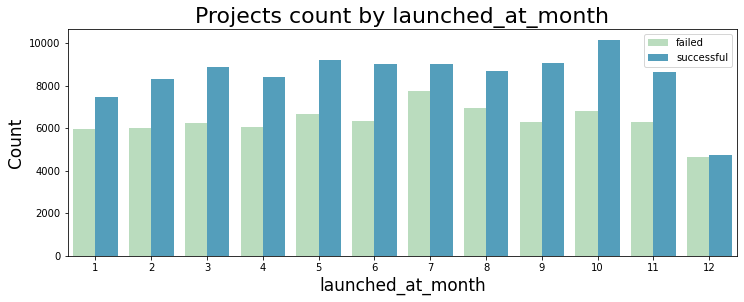

In [13]:
plot_column_state_compare(df, 'launched_at_month')

Plotting compare succussful or failed by launch weekday:


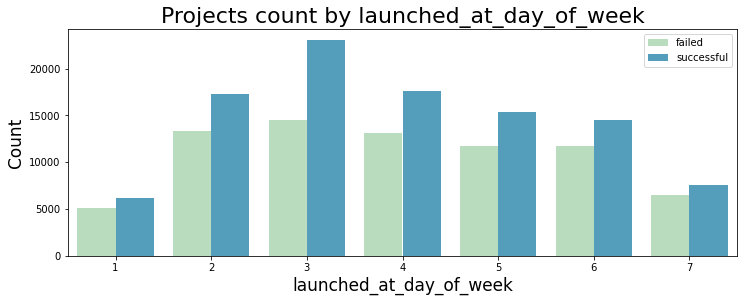

In [14]:
plot_column_state_compare(df, 'launched_at_day_of_week')

Plotting histogram:

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

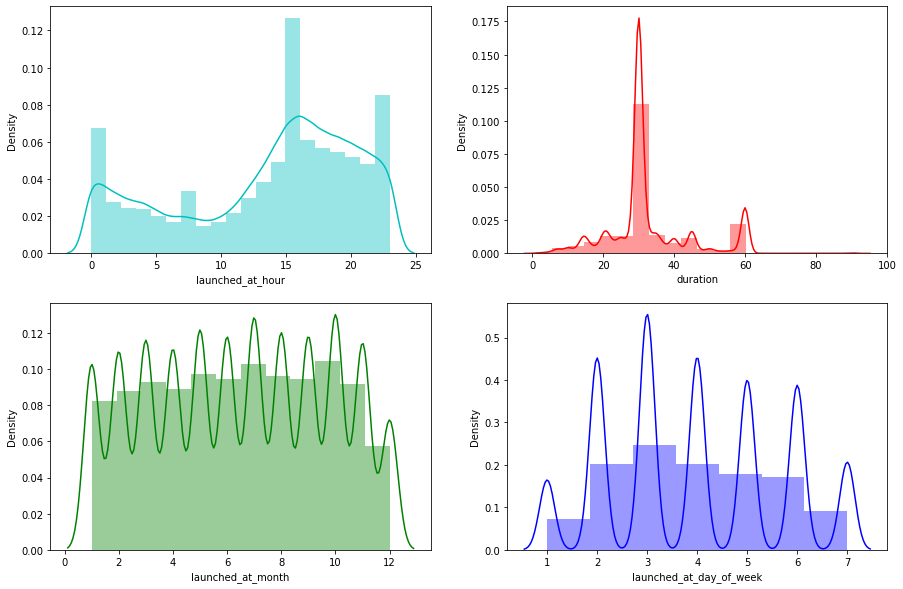

In [15]:
data = df.select(['launched_at_hour', 'duration', 'launched_at_month', 'launched_at_day_of_week']).toPandas()

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
sns.distplot(data.launched_at_hour, bins = 20, color = 'c', ax = ax1)
sns.distplot(data.duration, bins = 20, color = 'r', ax = ax2)
sns.distplot(data.launched_at_month, bins = 12, color = 'g', ax = ax3)
sns.distplot(data.launched_at_day_of_week, bins = 7, color = 'b', ax = ax4)

plt.show()

Plotting pair plot:

In [16]:
data = df.select(['state', 'launched_at_hour', 'launched_at_day_of_week', 'launched_at_month', 'duration', 'backers_count']).toPandas()

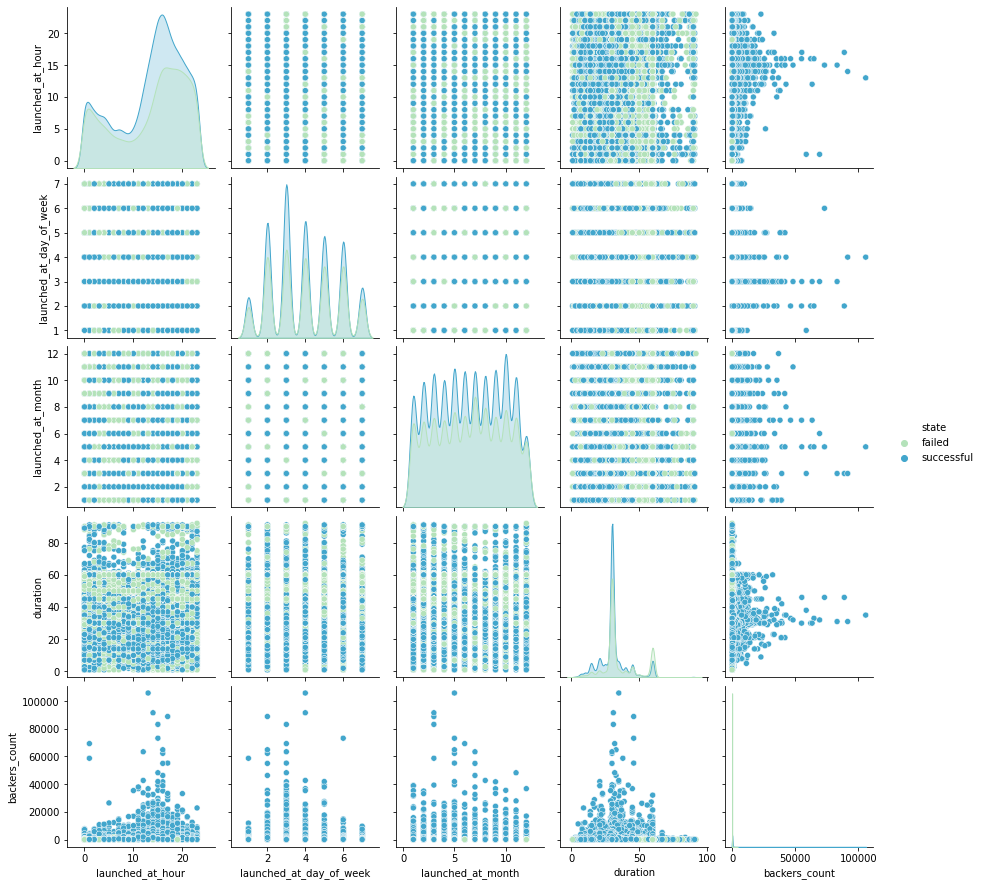

In [17]:
sns.pairplot(data, hue='state', palette = 'GnBu')

plt.show()

Check how timing impact on num of backers:

In [18]:
def plot_hue_state_map_compare(data, hue_column):
    """Plot hue state map compare of given column of the dataframe."""
    g = sns.FacetGrid(data, col="state", hue=hue_column, palette='GnBu', height=5)
    g.map(plt.scatter, hue_column, "backers_count", alpha=.7, linewidth=.5, edgecolor="white")
    g.add_legend()
    plt.show()

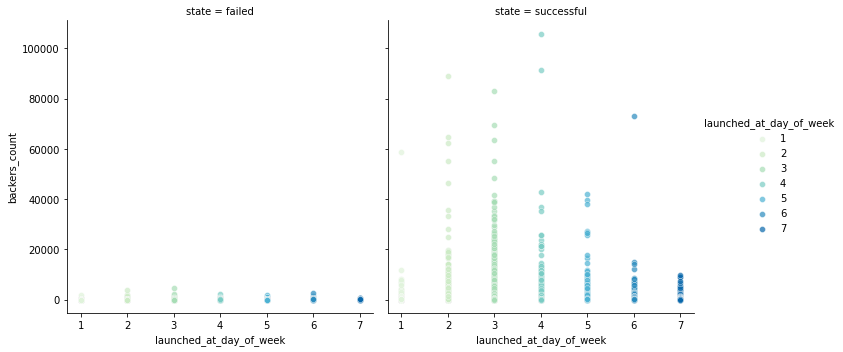

In [19]:
plot_hue_state_map_compare(data, 'launched_at_day_of_week')

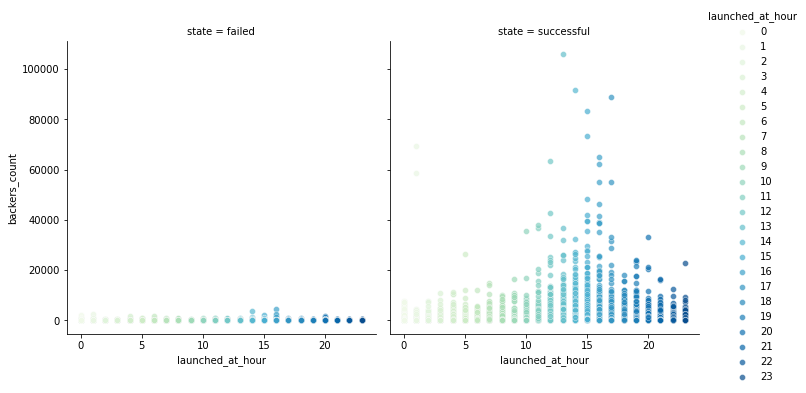

In [20]:
plot_hue_state_map_compare(data, 'launched_at_hour')

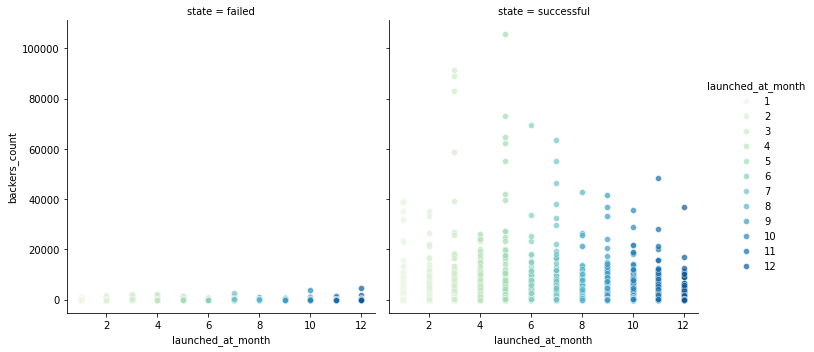

In [21]:
plot_hue_state_map_compare(data, 'launched_at_month')

In [22]:
spark.stop()

#Part 2.2: Conclusion
### * Recommended duration for a project is around 30 days since it's attracting more backers.
### * It's better to publish projects on Tuesday.
### * It's better to publish projects around 15:00.